# WB PD4 - Porównaj Expected SARSA oraz Q-learning
Marta Szuwarska

## Zadanie
Rozwiąż grę Cliff Walking z przykładu 6.6 oboma algorytmami. Porównaj rozwiązania. Zreprodukuj wykres z prawej części strony 132 z książki Barto, czyli na osi OX liczba epizodów, a na osi OY suma punktów zdobyta w czasie jednego epizodu.

Dlaczego Q-learning jest uważany za algorytm off-policy?

## Wybrana gra - Cliff Walking
Gra Cliff Walking jest grą, w której agent porusza się po planszy o wymiarach 12x4. Celem agenta jest dotarcie do celu, który znajduje się w prawym dolnym rogu planszy. Na planszy znajduje się również obszar, który jest klifem. Jeśli agent wejdzie na klif, to otrzymuje karę -100 i wraca na start. W przeciwnym wypadku agent otrzymuje karę -1 za każdy krok. Plansza wygląda następująco:

![cliff walking](./cliff_walking.png)

Obrazek pochodzi ze strony 132 książki Barto.

## Import bibliotek

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Implementacja środowiska gry

In [11]:
class CliffWalkingEnv:
    def __init__(self):
        self.width = 12
        self.height = 4
        self.start = (0, 0)
        self.goal = (11, 0)
        self.agent_pos = None
        self.reset()

    def reset(self) -> tuple:
        self.agent_pos = self.start
        return self.agent_pos

    def step(self, action) -> tuple:
        x, y = self.agent_pos
        if action == 0:  # up
            y = min(y + 1, self.height - 1)
        elif action == 1:  # right
            x = min(x + 1, self.width - 1)
        elif action == 2:  # down
            y = max(y - 1, 0)
        elif action == 3:  # left
            x = max(x - 1, 0)

        self.agent_pos = (x, y)
        
        if self.agent_pos == self.goal:
            return self.agent_pos, -1, True
        elif y == 0 and 1 <= x <= 10:
            self.agent_pos = self.start
            return self.agent_pos, -100, False
        else:
            return self.agent_pos, -1, False

## Implementacja Q-learning

In [13]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.width, env.height, 4))
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(4)
            else:
                action = np.argmax(Q[state])

            next_state, reward, done = env.step(action)
            total_reward += reward

            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            state = next_state

        rewards.append(total_reward)

    return Q, rewards

## Implementacja Expected SARSA

In [14]:
def expected_sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.width, env.height, 4))
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(4)
            else:
                action = np.argmax(Q[state])

            next_state, reward, done = env.step(action)
            total_reward += reward

            next_action_probs = np.ones(4) * epsilon / 4
            next_action_probs[np.argmax(Q[next_state])] += 1 - epsilon
            expected_q = np.dot(next_action_probs, Q[next_state])

            td_target = reward + gamma * expected_q
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta

            state = next_state

        rewards.append(total_reward)

    return Q, rewards

## Parametry

In [5]:
num_episodes = 500
alpha = 0.5
gamma = 1.0
epsilon = 0.1

## Porównanie Q-learning i Expected SARSA

In [15]:
env = CliffWalkingEnv()
q_learning_Q, q_learning_rewards = q_learning(env, num_episodes, alpha, gamma, epsilon)
expected_sarsa_Q, expected_sarsa_rewards = expected_sarsa(env, num_episodes, alpha, gamma, epsilon)

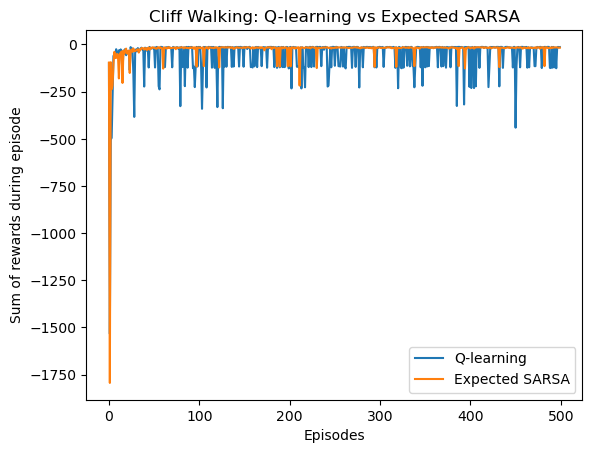

In [25]:
plt.plot(q_learning_rewards, label='Q-learning')
plt.plot(expected_sarsa_rewards, label='Expected SARSA')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend()
plt.title('Cliff Walking: Q-learning vs Expected SARSA')
plt.show()

Powyżej widać wykres porównujący sumę punktów zdobytych w czasie jednego epizodu dla algorytmów Q-learning i Expected SARSA. Widać, że oba algorytmy osiągają podobne wyniki, ale Expected SARSA zdaje się być bardziej stabilny. Q-learning zdaje się wybierać bardziej ryzykowne akcje, co może prowadzić do optymalnej ścieżki, ale również do większych kar. W celu czytelniejszego zobrazowania tego zachowania zastosowałam też ruchomą średnią z oknem 10 epizodów, którą widać na wykresie poniżej. 

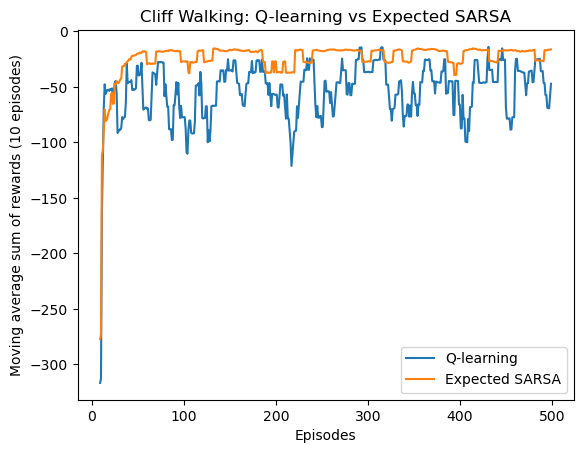

In [28]:
window_size = 10
moving_avg_q_learning = pd.Series(q_learning_rewards).rolling(window=window_size).mean()
moving_avg_expected_sarsa = pd.Series(expected_sarsa_rewards).rolling(window=window_size).mean()

plt.plot(moving_avg_q_learning, label='Q-learning')
plt.plot(moving_avg_expected_sarsa, label='Expected SARSA')
plt.xlabel('Episodes')
plt.ylabel('Moving average sum of rewards (10 episodes)')
plt.legend()
plt.title('Cliff Walking: Q-learning vs Expected SARSA')
plt.show()

## Dlaczego Q-learning jest uważany za algorytm off-policy?
Q-learning jest uważany za algorytm off-policy, ponieważ aktualizuje wartości Q na podstawie maksymalnej wartości Q dla następnego stanu, niezależnie od tego, jaką akcję wybrałby agent. 